# Homework 2 : Implementation of KNN Classifier on Income Data Set

* This note book contains sections:
    1. Preprocessing the data for implementing KNN
    2. Functions that are used for the similarities
    3. KNN algorithm
    4. Evaluation of Classifier using weighted distances
    5. Evaluation of Classifier using Majority votes
    6. ROC curves, for vaious values of k and different proximity functions, ROC curves are plotted to choose the curve with max area under ROC curve
    7. Applying our algorithm on training data
    8. Comparing KNN to an off the shelf classifier

In [1]:
# importing all the required packages 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

* Importing the data from the csv files.

In [2]:
train = pd.read_csv("income_tr.csv")
test = pd.read_csv("income_te.csv")

# 1. Preprocessing

* Since we already did the data analysis in HW1, for the sake of keeping this notebook short we will skip the EDA.
* Let us implement all the preprocessing techniques we used for the homework1
* First, we will scale the data of train and test data set for the attributes 'age', 'fnlwgt', 'hour_per_week'

In [3]:
train[['age','fnlwgt','hour_per_week']] = train[['age','fnlwgt','hour_per_week']].apply(lambda x : (x - np.min(x)) / (np.max(x) - np.min(x)))
test[['age','fnlwgt','hour_per_week']] = test[['age','fnlwgt','hour_per_week']].apply(lambda x : (x - np.min(x)) / (np.max(x) - np.min(x)))

* If we remember correctly, we decided that education and education_cat are the same attributes and hence we decided to drop education. 
* ID will not contribute to the classification and hence we can drop ID.
* These changes are done to both the test set and the training set.

In [4]:
train.drop("education", axis = 1, inplace = True)
test.drop("education", axis = 1, inplace = True)
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

## Missing values

* As we can recall, there were missing values in occupation, workclass and native_country attributes. We replace the missing values in occupation and workclass with Job_X and X and we replaced the missing values in native_country with the most frequent value.

In [5]:
train["occupation"].replace(to_replace ="\?" , value = "Job_X", inplace = True, regex = True)
train["workclass"].replace(to_replace="\?", value = "X", inplace = True, regex=True)
train["native_country"].replace(to_replace = "\?", value = "United-States", inplace = True, regex = True)

### Encoding the class attribute values

* To understand the class variable easily when we look at it, we will encode the values as either 0 or 1 in place of ">50" or '<=50' respectively. This will help us easily to relate with True Positives, False Positives, True Negatives and False negatives and the confusion matrix.

In [6]:
#replacing the class attribute values with 0 and 1 for training set
train['class'].replace(to_replace = "<=50", value = 1, inplace = True, regex = True)
train['class'].replace(to_replace = ">50", value = 0, inplace = True, regex = True)
#replacing the class attrubute values with 0 and 1 for test set
test['class'].replace(to_replace = "<=50", value = 1, inplace = True, regex = True)
test['class'].replace(to_replace = ">50", value = 0, inplace = True, regex = True)

* We will now seperate the class attribute into a seperate dataframe for both the training and the test set. Once we do that, we can drop the class attribute from train and test dataframes as it will be easy for us to use the off the shelf classifier.

In [7]:
y_train = train[['class']]
y_test = test[['class']]
train.drop("class", axis = 1, inplace = True)
test.drop("class", axis = 1, inplace = True)

# 2. Functions

* Let us now define the functions that are going to be useful our KNN classification. There are only two function required here i.e.
    1. Nominal variable Similarity (nom_sim)
    2. Ordinal variable Similarity (ord_sim)
* We will include the distance calculation within the KNN algorithm itself.

In [8]:
# This is the function for nominal similarity. Returns a distance equal to 0 if both are similar.
def nom_sim(train, test):
    if test == train:
        return 0
    else:
        return 1

In [9]:
# This is the function for ordinal similarity. 
# The functions parameters are values of test and train data and the unique values of that attribute
def ord_sim(train, test, n):
    train = train - 1
    test = test - 1
    d = abs(train - test) / (n - 1)
    return d

# 3. KNN CLASSIFIER

In [10]:
targets = []
targets_with_dist = []
prob = []
k = 17
for i in range(len(test)):
    distances = []
    for j in range(len(train)):
        # d here calculates the euclidian distance of three continuous attributes age, hour_per_week, fnlwgt
        #d =  np.sqrt(np.sum(np.square(test[['age','fnlwgt', 'hour_per_week']].iloc[i,:] - train[['age','fnlwgt','hour_per_week']].iloc[j, :])))
        
        # d1, d2, d3 are the distances between the test and the training examples for the continuous attributes.
    
        d1 = np.abs(test['age'].iloc[i] - train['age'].iloc[j])        
        d2 = np.abs(test['fnlwgt'].iloc[i] - train['fnlwgt'].iloc[j])        
        d3 = np.abs(test['hour_per_week'].iloc[i] - train['hour_per_week'].iloc[j])        
        
        # a,b,c,d,e,f,g,h,t are the distances for the nominal attributes. For the the first assignment we used jaccard similarity
        # for capital_gain and capital_loss. For this we will simply use nominal distance metric which is defined above. It simply
        # implies that if two records are similar then the distance between them is 0. 
        
        # distance calculation for all the nominal attributes
        a = nom_sim(train["marital_status"].iloc[j], test["marital_status"].iloc[i])
        b = nom_sim(train["occupation"].iloc[j], test["occupation"].iloc[i])
        c = nom_sim(train["relationship"].iloc[j], test["relationship"].iloc[i])
        d = nom_sim(train["race"].iloc[j], test["race"].iloc[i])
        e = nom_sim(train["gender"].iloc[j], test["gender"].iloc[i])
        f = nom_sim(train["native_country"].iloc[j], test["native_country"].iloc[i])
        g = nom_sim(train["workclass"].iloc[j], test["workclass"].iloc[i])
        h = nom_sim(train["capital_loss"].iloc[j],test["capital_loss"].iloc[i])
        t = nom_sim(train["capital_gain"].iloc[j],test["capital_gain"].iloc[i])
        
        # s is the distance calculation for the ordinal attribute education_cat.
        s = ord_sim(train["education_cat"].iloc[j], test["education_cat"].iloc[i], len(train["education_cat"].unique()))
        
        # Commented out is the distance calculation if euclidian is included in the algorithm. 
#         distance = (d * 3 + a + b + c + d + e + f + g + h + t + s) / 13
        
        # Since we are calculating the manhattan path, we will only use d1, d2, d3
        distance = (d1 + d2 + d3 + a + b + c + d + e + f + g + h + t + s) / 13
        
        # This will append the distances and give each distance an index, j here will act as an identifier
        distances.append([distance, j])    
        
    # Sorting the distances for each test example
    
    distances = sorted(distances)
    
    # We will subset the k nearest neeighbors
    
    for l in range(k):
        index = distances[l][1]
        dist = distances[l][0]
        targets_with_dist.append([dist, y_train.iloc[index]])
        targets.append(y_train.iloc[index])
#     prob.append([Counter(targets) , len(Counter(targets).most_common(21)[0][0])])    
    #del distances

* We will input these k similar items into a dataframe *df_ksim* 

In [11]:
k_similar = np.array(targets_with_dist)
new_ksim = np.reshape((k_similar), (len(test),2*k))
df_ksim = pd.DataFrame(data = new_ksim)

# 4. Weighted distance

* We will calculate the weighted distances for each nearest neighbor. We will then pick the class which has the highest ratio of the weights.
* Along with the weighted distances, we will also count the number of ones and zeros for calculating the posterior probabilities for a given k.

In [12]:
# count_1 and count_0 are lists which will append the number of ones and zeros
count_1 = []
count_0 = []

## prob_1, prob_0 and prob are for the posteriors which will create a data frame
prob = []

# prob1 will append all the posterior probabilities of P(1|x)
prob1 = []
pred_class = []
#pred list is for appending the weighted distance probabilities.
pred = []


# Looping through the data frame of size 288 x 2*k
for i in range(len(df_ksim)):
    avg_1 = 0
    avg_0 = 0
    c_0 = 0
    c_1 = 0
    d1 = 0
    d2 = 0
    for j in range(0,2*k-1,2):
        if df_ksim[j+1][i] == 1:
            # if distance = 0, it will return NaN values for 1/0. T0 avoid that we will include this condition
            if df_ksim[j][i] == 0:
                avg_1 = avg_1
            else:
                #calculating the inverse square of distances
                d1 = 1/np.square(df_ksim[j][i])#np.exp(df_ksim[j][i])
                avg_1 = d1 + avg_1
            c_1 = c_1 + 1     
        elif df_ksim[j+1][i] == 0:
            if df_ksim[j][i] == 0:
                avg_0 = avg_0
            else:
                d2 = 1/np.square(df_ksim[j][i])#np.exp(df_ksim[j][i])
                avg_0 = d2 + avg_0
            c_0 = c_0 + 1
    prob_1 = (c_1/(c_1+c_0))
    # Now we will append the posterior probabilities of 1 given X
    prob1.append(prob_1)
    prob_0 = (c_0/(c_1+c_0))
    p = avg_1/(avg_1+avg_0)
    q = avg_0/(avg_1+avg_0)
    count_1.append(c_1)
    count_0.append(c_0)
    
    
    # posteriors for the m x 4 data frame
    if prob_1 > prob_0:
        prob.append(prob_1)
        pred_class.append(1)
    else:
        prob.append(prob_0)
        pred_class.append(0)

    #This will append the class and the probabilities of weighted distances
    if p > q:
        pred.append([1,p])
    else:
        pred.append([0,q])

## Genearting the M x 4 dataframe

* Here class in the dataframe implies the actual class 

In [13]:
Transaction_ID = list(range(1,289))
tid = pd.DataFrame(Transaction_ID, columns=['Transaction_ID'])
pred_class = pd.DataFrame(data = pred_class, columns=['Predicted Class'])
prob = pd.DataFrame(data = prob, columns = ['Posterior Probabilities'])
df_output = pd.concat((tid, y_test,pred_class,prob), axis=1)

In [14]:
df_output['class'].replace(to_replace = 1, value = '<=50',inplace = True)
df_output['class'].replace(to_replace = 0, value = '>50', inplace = True)
df_output['Predicted Class'].replace(to_replace = 1, value = '<=50',inplace = True)
df_output['Predicted Class'].replace(to_replace = 0, value = '>50', inplace = True)
df_output.to_csv("Final DataFrame.csv")
df_output.head()

,Transaction_ID,class,Predicted Class,Posterior Probabilities
0,1,<=50,<=50,0.823529
1,2,<=50,<=50,0.823529
2,3,>50,<=50,0.588235
3,4,<=50,<=50,0.764706
4,5,<=50,<=50,0.823529


In [15]:
pred = pd.DataFrame(pred)

## Computing True Positive, False Positive, True negative and False negative rates, Recall, Precision and F-Measure based on the weighted distances.

In [16]:
T1 = 0
T0 = 0 
F1 = 0
F0 = 0
for i in range(len(pred)):
    if y_test['class'][i] == pred[0][i] and pred[0][i] == 1:
        T1 = T1 + 1
    if y_test['class'][i] == pred[0][i] and pred[0][i] == 0:
        T0 = T0 + 1
    if y_test['class'][i] != pred[0][i] and pred[0][i] == 1:
        F1 = F1 + 1
    if y_test['class'][i] != pred[0][i] and pred[0][i] == 0:
        F0 = F0 + 1

#True Positive Rate 
T1R = T1/(T1+F0)
print("True Positive Rate(TPR) or Sensitivity: {}".format(T1R))
T0R = T0/(T0 + F1)
print("True Negative Rate(TNR) or Specificity: {}".format(T0R))
F1R = F1/(F1 + T0)
print("False Positive Rate(FPR): {}".format(F1R))
F0R = F0/(F0 + T1)
print("False Negative Rate(FNR): {}".format(F0R))
prec = T1/(T1+F1)
print("Precision :{}".format(prec))
r = T1/(T1+F0)
print("Recall :{}".format(r))
F = 2*T1/(2*T1 + F1 + F0)
print("F-measure :{}".format(F))

True Positive Rate(TPR) or Sensitivity: 0.8959276018099548
True Negative Rate(TNR) or Specificity: 0.29850746268656714
False Positive Rate(FPR): 0.7014925373134329
False Negative Rate(FNR): 0.10407239819004525
Precision :0.8081632653061225
Recall :0.8959276018099548
F-measure :0.8497854077253219


## Confusion Matrix for the weighted distance model

In [17]:
df = pd.DataFrame({'' : ('<=50','>50'),'>50':(str(F0),str(T0)),'<=50':(str(T1), str(F1))})
df.index = df['']
del df['']
df.index.rename('Actual Class', inplace = True)
df.columns.rename('Predicted Class =>', inplace = True)
df

Predicted Class =>,<=50,>50
Actual Class,,
<=50,198,23
>50,47,20


## Weighted distance accuracy

* For checking the accuracy of the model, let us import sklearn package.
* We will import the metric accuracy_score from this package
* The accuracy of the model with k = 23 is 0.7673 by using the weighted distance model which can be seen below

In [18]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred[0]))

0.756944444444


# 5. Majority vote

* Let us predict the class of the income variable using the majority vote, i.e. in a set of k neighbors we will pick the class that has more than 50% probability.
* We will then calculate the accuracy and its performance measures.

In [19]:
count_1 = pd.DataFrame(data=(count_1), columns = ['count_1'])
count_0 = pd.DataFrame(data=(count_0), columns = ['count_0'])
prob_1 = pd.DataFrame(data=(prob1), columns=['prob(1|x)'])
count = pd.concat((count_1,count_0), axis = 1)
pred2 = []
for i in range(len(count)):
    if count['count_1'][i] > count['count_0'][i]: 
        pred2.append([1])
    else:
        pred2.append([0])
pred2 = pd.DataFrame(data = pred2, columns=['pred_class'])
pred2 = pd.concat((pred2, prob_1), axis=1)
pred2.head()

,pred_class,prob(1|x)
0,1,0.823529
1,1,0.823529
2,1,0.588235
3,1,0.764706
4,1,0.823529


## Accuracy of model for Majority vote system:

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred2['pred_class']))

0.78125


### Computing True Positive, False Positive, True negative and False negative rates, Recall, Precision and F-Measure based on Majority votes

In [21]:
T1 = 0
T0 = 0 
F1 = 0
F0 = 0
for i in range(len(pred2['pred_class'])):
    if y_test['class'][i] == pred2['pred_class'][i] and pred2['pred_class'][i] == 1:
        T1 = T1 + 1
    if y_test['class'][i] == pred2['pred_class'][i] and pred2['pred_class'][i] == 0:
        T0 = T0 + 1
    if y_test['class'][i] != pred2['pred_class'][i] and pred2['pred_class'][i] == 1:
        F1 = F1 + 1
    if y_test['class'][i] != pred2['pred_class'][i] and pred2['pred_class'][i] == 0:
        F0 = F0 + 1
        
#True Positive Rate 
T1R = T1/(T1+F0)
print("True Positive Rate(TPR) or Sensitivity: {}".format(T1R))
T0R = T0/(T0 + F1)
print("True Negative Rate(TNR) or Specificity: {}".format(T0R))
F1R = F1/(F1 + T0)
print("False Positive Rate(FPR): {}".format(F1R))
F0R = F0/(F0 + T1)
print("False Negative Rate(FNR): {}".format(F0R))
prec = T1/(T1+F1)
print("Precision :{}".format(prec))
r = T1/(T1+F0)
print("Recall :{}".format(r))
F = (2*T1)/(2*T1 + F1 + F0)
print("F-measure :{}".format(F))

True Positive Rate(TPR) or Sensitivity: 0.9276018099547512
True Negative Rate(TNR) or Specificity: 0.29850746268656714
False Positive Rate(FPR): 0.7014925373134329
False Negative Rate(FNR): 0.07239819004524888
Precision :0.8134920634920635
Recall :0.9276018099547512
F-measure :0.8668076109936576


## Confusion matrix of un-weighted model

In [22]:
df = pd.DataFrame({'' : ('<=50','>50'),'>50':(F0,T0),'<=50':(T1, F1)})
df.index = df['']
del df['']
df.index.rename('Actual Class', inplace = True)
df.columns.rename('Predicted Class =>', inplace = True)
df

Predicted Class =>,<=50,>50
Actual Class,,
<=50,205,16
>50,47,20


# 6.Plotting ROC curve
* By varying the values of k between from 23 to 43 by increments of 10, distance metric i.e. either euclidian or manhattan on continuous attribute and the method of choosing the nearest neghbor.
* Calculating different values for the ROC curve was difficult, plotting just 12 points took 45-55 minutes. Producing the roc curve with minimum data. We will select a point which will have major lift
* Based on curve, we are getting a major lift at FPR = 0.70 and TPR = 0.93. These are the values obtained for k = 23, method of predicting class is by majority vote and Manhattan distance is used for calcualating the distance between test and training data.
* The same proximity functions were used for the nominal and oridnal attributes. Proximity function for continuous attributes age, hour_per_week and fnlwgt were changed between euclidian to manhattan distance.


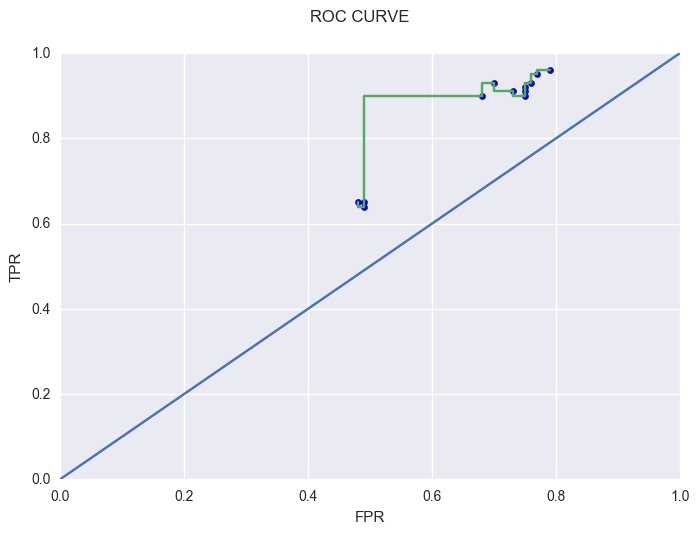

In [23]:
# Recorded this data into excel by varying the values of k, distance metric and the method of choosing the nearest neighbor
data = [[0.68,0.9], [0.70,0.93], [0.75,0.9],[0.77,0.95],[0.49,0.64],[0.75,0.92],[0.48,0.65],[0.75,0.91],[0.49,0.65],[0.76,0.93],[0.73,0.91],[0.79,0.96]]
data = sorted(data)
fig = plt.figure()
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
fig.suptitle("ROC CURVE")
plt.xlabel("FPR")
plt.ylabel("TPR")
x = [0,1]
plt.plot(x,x)
roc_df = pd.DataFrame(data = data)
x  = roc_df[0]
y = roc_df[1]
plt.step(x,y)
data
plt.scatter(x,y)

## ROC CURVE with sklearn (IMPORTANT TO LOOK AT WHAT DATA WE ARE USING FOR CALCULATIONS: REFER LINE 6 IN THE CODE BELOW)
* As it is difficult to interpret the curve, we will use the curve plot from sklearn on our data. 
* In our dataframe *pred2* we have a column which has the posterior probabilities of 1 given x which means P(<=50 | X) for all the values of test examples. We will use this value in our functions below

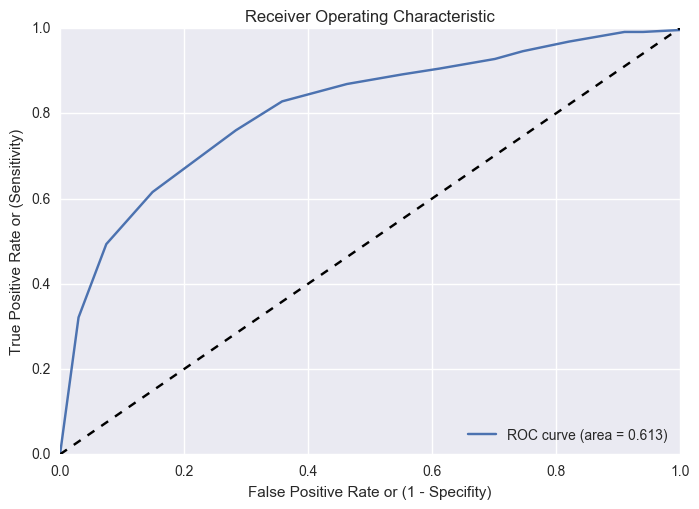

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# pred2['prob(1|x)'] is the important thing for our calculation of ROC CURVE
fpr, tpr, thresholds = roc_curve(y_test, pred2['prob(1|x)'])
roc_a = auc(fpr,tpr)
roc_auc = roc_auc_score(y_test, pred2['pred_class'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 7. Implementing KNN classifier on income training data
* We will add '_tr' to all the variable names and we will perform the majority vote to choose the class.
* Also, we will comment out this block of code once we are done with evaluating the accuracy for conevenience of re-running the code for the initial part of the program.

In [25]:
targets = []
targets_with_dist_tr = []
prob = []
k = 23
for i in range(len(train)):
    distances_tr = []
    for j in range(len(train)):
        # d_tr here calculates the euclidian distance of three continuous attributes age, hour_per_week, fnlwgt
        # d_tr =  np.sqrt(np.sum(np.square(test[['age','fnlwgt', 'hour_per_week']].iloc[i,:] - train[['age','fnlwgt','hour_per_week']].iloc[j, :])))
        
        # d1_tr, d2_tr, d3_tr are the distances between the test and the training examples for the continuous attributes.
    
        d1_tr = np.abs(train['age'].iloc[i] - train['age'].iloc[j])        
        d2_tr = np.abs(train['fnlwgt'].iloc[i] - train['fnlwgt'].iloc[j])        
        d3_tr = np.abs(train['hour_per_week'].iloc[i] - train['hour_per_week'].iloc[j])        
        
        # a,b,c,d,e,f,g,h,t are the distances for the nominal attributes. For the the first assignment we used jaccard similarity
        # for capital_gain and capital_loss. For this we will simply use nominal distance metric which is defined above. It simply
        # implies that if two records are similar then the distance between them is 0. 
        
        # distance calculation for all the nominal attributes
        a_tr = nom_sim(train["marital_status"].iloc[j], train["marital_status"].iloc[i])
        b_tr = nom_sim(train["occupation"].iloc[j], train["occupation"].iloc[i])
        c_tr = nom_sim(train["relationship"].iloc[j], train["relationship"].iloc[i])
        d_tr = nom_sim(train["race"].iloc[j], train["race"].iloc[i])
        e_tr = nom_sim(train["gender"].iloc[j], train["gender"].iloc[i])
        f_tr = nom_sim(train["native_country"].iloc[j], train["native_country"].iloc[i])
        g_tr = nom_sim(train["workclass"].iloc[j], train["workclass"].iloc[i])
        h_tr = nom_sim(train["capital_loss"].iloc[j],train["capital_loss"].iloc[i])
        t_tr = nom_sim(train["capital_gain"].iloc[j],train["capital_gain"].iloc[i])
        
        # s is the distance calculation for the ordinal attribute education_cat.
        s_tr = ord_sim(train["education_cat"].iloc[j], train["education_cat"].iloc[i], len(train["education_cat"].unique()))
        
        
        # Since we are calculating the manhattan path, we will only use d1, d2, d3
        distance_tr = (d1_tr + d2_tr + d3_tr + a_tr + b_tr + c_tr + d_tr + e_tr + f_tr + g_tr + h_tr + t_tr + s_tr) / 13
        
        # This will append the distances and give each distance an index, j here will act as an identifier
        distances_tr.append([distance_tr, j])    
        
    # Sorting the distances for each test example
    
    distances_tr = sorted(distances_tr)
    
    # We will subset the k nearest neeighbors
    
    for l in range(k):
        index_tr = distances_tr[l][1]
        dist_tr = distances_tr[l][0]
        targets_with_dist_tr.append([dist_tr, y_train.iloc[index_tr]])
        targets.append(y_train.iloc[index])
#     prob.append([Counter(targets) , len(Counter(targets).most_common(21)[0][0])])    
k_similar_tr = np.array(targets_with_dist_tr)
new_ksim_tr = np.reshape((k_similar_tr), (len(train),2*k))
df_ksim_tr = pd.DataFrame(data = new_ksim_tr)


# count_1 and count_0 are lists which will append the number of ones and zeros
count_1 = []
count_0 = []
prob_1 = []
pred_tr = []
for i in range(len(df_ksim_tr)):
    c_0 = 0
    c_1 = 0
    for j in range(0,2*k-1,2):
        if df_ksim_tr[j+1][i] == 1:
            c_1 = c_1 + 1 
        elif df_ksim_tr[j+1][i] == 0:
            c_0 = c_0 + 1
    count_1.append(c_1)
    count_0.append(c_0)
    prob_1.append(c_1/(c_1+c_0))
count_1 = pd.DataFrame(data=(count_1), columns = ['count_1'])
count_0 = pd.DataFrame(data=(count_0), columns = ['count_0'])
count = pd.concat((count_1,count_0), axis = 1)
for i in range(len(count)):
    if count['count_1'][i] > count['count_0'][i]:
        pred_tr.append([1])
    else:
        pred_tr.append([0])
pred_tr = pd.DataFrame(data = pred_tr)



count_1 = pd.DataFrame(data=(count_1), columns = ['count_1'])
count_0 = pd.DataFrame(data=(count_0), columns = ['count_0'])
prob_1 = pd.DataFrame(data=(prob_1), columns=['prob(1|x)'])
count = pd.concat((count_1,count_0), axis = 1)
pred2_tr = []
for i in range(len(count)):
    if count['count_1'][i] > count['count_0'][i]: 
        pred2_tr.append([1])
    else:
        pred2_tr.append([0])
pred2_tr = pd.DataFrame(data = pred2_tr, columns=['pred_class'])
pred2_tr = pd.concat((pred2_tr, prob_1), axis=1)
pred2_tr.head()

,pred_class,prob(1|x)
0,1,0.826087
1,1,0.782609
2,1,1.000000
3,1,1.000000
4,1,0.956522


### Accuracy on training data
* As we can see our algorithm returned an accuracy of 84.6% on the training data

In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, pred2_tr['pred_class']))

0.846153846154


# 8. OFF-THE-SHELF

* Let us use the knn classifier from sklearn.neigbors.
* Since we cannot use different distance metric on the different types of attribute available, we will encode every nominal variable and then simply calculate their distances.
* We will use the weighted distances for and the uniform weights to see the difference.

In [27]:
# importing the classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

In [28]:
#Identifying nominal features in test and training sets
nominal_features_train = [f for f in train.columns if train[f].dtype.name == "object"]
nominal_features_test = [f for f in test.columns if test[f].dtype.name == "object"]

In [29]:
# Identifying ratio features in test and training data sets
ratio_features_train = set(train.columns) - set(nominal_features_train)
ratio_features_test = set(test.columns) - set(nominal_features_test)

* Encoding the records of nominal attributes for training data based on the unique values that are in each attribute.

In [30]:
for feature in nominal_features_train:
    feature_unique = train[feature].unique()
    train[feature] = train[feature].map(dict(
        zip(feature_unique, range(len(feature_unique)))))
train[nominal_features_train] = train[nominal_features_train].apply(lambda f: f.astype("category"))
train.head()

,age,workclass,fnlwgt,education_cat,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hour_per_week,native_country
0,0.323077,0,0.280977,9,0,0,0,0,0,0,0,0.391753,0
1,0.215385,0,0.123620,9,0,1,0,0,0,0,0,0.505155,0
2,0.138462,0,0.207971,9,1,2,1,1,1,0,0,0.391753,1
3,0.507692,1,0.120538,3,1,3,2,2,1,0,0,0.134021,0
4,0.276923,0,0.636417,9,1,0,2,0,1,0,0,0.391753,0


* Encoding the records of nominal attributes for test data based on the unique values that are in each attribute.

In [31]:
for features in nominal_features_test:
    features_unique = test[features].unique()
    test[features] = test[features].map(dict(
        zip(features_unique, range(len(features_unique)))))
test[nominal_features_test] = test[nominal_features_test].apply(lambda f: f.astype("category"))
test.head()

,age,workclass,fnlwgt,education_cat,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hour_per_week,native_country
0,0.237288,0,0.051917,10,0,0,0,0,0,0,1672,0.494845,0
1,0.694915,0,0.291349,11,1,1,1,0,1,0,0,0.391753,0
2,0.677966,1,0.244483,10,0,1,0,1,0,0,0,0.340206,0
3,0.322034,2,0.330674,9,0,2,0,0,0,0,0,0.340206,0
4,0.423729,0,0.301862,9,2,3,2,0,0,0,0,0.391753,1


### Implementing the classifier
* We will use the same k value that we obtained from the previous analysis. For this k, we observed area under curve of 0.635 which was the maximum noticed after varying the values of k.

In [32]:
knn = KNeighborsClassifier(n_neighbors=17,weights='distance', p = 1).fit(train, y_train)
probas = KNeighborsClassifier(n_neighbors=17,weights='distance', p = 1).fit(train, y_train).predict_proba(test)

C:\Users\Yashwanth\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\Users\Yashwanth\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


### Accuracy of the model

In [33]:
ots_knn = knn.predict(test)
print(accuracy_score(y_test,ots_knn))

0.798611111111


## Confusion Matrix and Performance Measure

In [34]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,ots_knn).ravel()
df_ots = pd.DataFrame({'' : ('<=50','>50'),'>50':(fn,tn),'<=50':(tp, fp)})
df_ots.index = df_ots['']
del df_ots['']
df_ots.index.rename('Actual Class', inplace = True)
df_ots.columns.rename('Predicted Class =>', inplace = True)
tpr = tp/(tp+fn)
print("True Positive Rate(TPR) or Sensitivity: {}".format(tpr))
tnr = tn/(tn + fp)
print("True Negative Rate(TNR) or specificity: {}".format(tnr))
fpr = fp/(fp + tn)
print("False Positive Rate(FPR): {}".format(fpr))
fnr = fn/(fn + tp)
print("False Negative Rate(FNR): {}".format(fnr))
prec = tp/(tp+fp)
print("Precision :{}".format(prec))
r = tp/(tp+fn)
print("Recall :{}".format(r))
F = (2*tp)/(2*tp + fp + fn)
print("F-measure :{}".format(F))
print("\nCONFUSION MATRIX")
df_ots

True Positive Rate(TPR) or Sensitivity: 0.9411764705882353
True Negative Rate(TNR) or specificity: 0.3283582089552239
False Positive Rate(FPR): 0.6716417910447762
False Negative Rate(FNR): 0.058823529411764705
Precision :0.8221343873517787
Recall :0.9411764705882353
F-measure :0.8776371308016878

CONFUSION MATRIX


Predicted Class =>,<=50,>50
Actual Class,,
<=50,208,13
>50,45,22


### ROC CURVE
* We will plot the ROC curve for this 

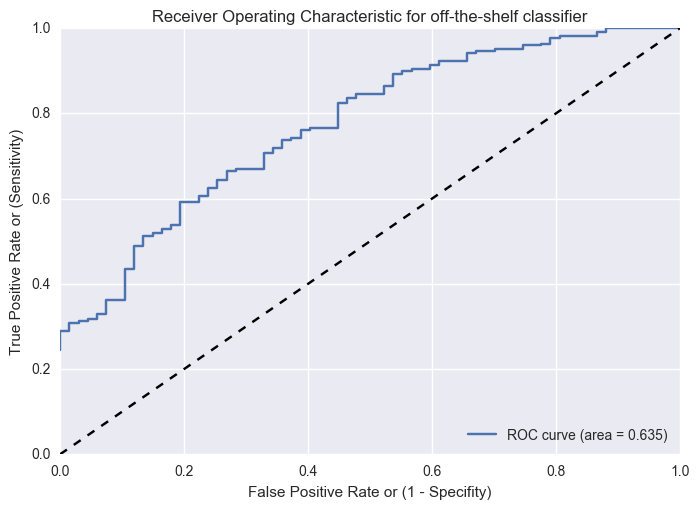

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
roc_auc = roc_auc_score(y_test, ots_knn)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic for off-the-shelf classifier')
plt.legend(loc="lower right")